# Spaceship Titanic

Predict which passengers are transported to an alternate dimension

Current Rank: 690/1572 (Top 44%)
Current Score: 0.79237

### File and Data Field Descriptions

<details>
<summary>Click to expand</summary>

train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
+ PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the 
group. People in a group are often family members, but not always.
+ HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
+ CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
+ Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
+ Destination - The planet the passenger will be debarking to.
+ Age - The age of the passenger.
+ VIP - Whether the passenger has paid for special VIP service during the voyage.
+ RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
+ Name - The first and last names of the passenger.
+ Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

+ test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
sample_submission.csv - A submission file in the correct format.
+ PassengerId - Id for each passenger in the test set.
+ Transported - The target. For each passenger, predict either True or False.

</details>

In [37]:
# import the necessary packages
from datetime import datetime as time
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from tensorflow.keras import callbacks
from tensorflow.keras import models as k_models
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from Kaggle.Challenges.utils import make_mi_scores, plot_mi_scores

plt.figure(dpi=100, figsize=(8, 5))

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [38]:
# Importing the dataset
train = pd.read_csv('data/space_train.csv')
test = pd.read_csv('data/space_test.csv')

In [39]:
def feature_engineering(df: pd.DataFrame):
    
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    df['CryoSleep'] = df['CryoSleep'].fillna(False)
    df['Cabin'] = df['Cabin'].fillna('U/0/U')
    df['RoomNumber'] = df['PassengerId'].str.split('_').str[1].astype(int)
    df['RoomService'] = df['RoomService'].fillna(0)
    df['FoodCourt'] = df['FoodCourt'].fillna(0)
    df['ShoppingMall'] = df['ShoppingMall'].fillna(0)
    df['Spa'] = df['Spa'].fillna(0)
    df['VRDeck'] = df['VRDeck'].fillna(0)
    df['TotalServicesFee'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']
    df[['Deck', 'Num','Side']] = df['Cabin'].str.split('/', expand=True)
    df['Num'] = df['Num'].astype(int)
    
    df = df.drop('Cabin', axis=1)
    
    cols = [
        'PassengerId',
        'Name',
        'VIP',
        'Destination',
        'HomePlanet',
        'Side'
    ]
    
    df = df.drop(cols, axis=1)
    
    # Transform boolean columns to integer
    bool_col = df.select_dtypes(include=['bool']).columns
    df[bool_col] = df[bool_col].astype(int)
    
    ordinal_encoder = OrdinalEncoder()
    cat_columns = df.select_dtypes(include=['object']).columns
    df[cat_columns] = ordinal_encoder.fit_transform(df[cat_columns])
    
    # Use Scaler for data
    # scaler = MinMaxScaler(feature_range=(0, 1))
    # df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    return df

In [40]:
transformed_train = feature_engineering(train)

C:\Users\Tymur_Hilfatullin\AppData\Local\Temp\ipykernel_12084\1330618289.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['CryoSleep'] = df['CryoSleep'].fillna(False)


In [41]:
X = transformed_train.drop('Transported', axis=1)
y = transformed_train['Transported']

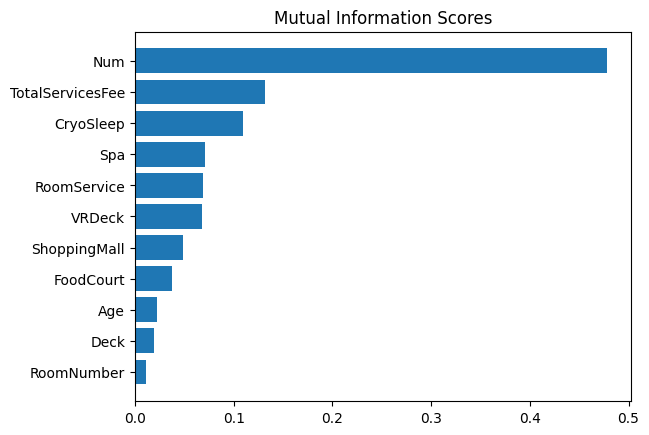

In [42]:
# Investigate MI of data
discrete_features = X.dtypes == int # All discrete features should now have integer dtypes (double-check this before using MI!)
mi_scores = make_mi_scores(X, y, discrete_features)
plot_mi_scores(mi_scores)

In [43]:
# prepare data for model
random_state = int(time.now().timestamp()) % 4294967295
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

TotalServicesFee    0.161300
Deck                0.124679
Spa                 0.116183
CryoSleep           0.115828
VRDeck              0.105172
RoomService         0.090624
FoodCourt           0.085520
Num                 0.072609
ShoppingMall        0.062172
Age                 0.052096
RoomNumber          0.013816
dtype: float64


<Axes: >

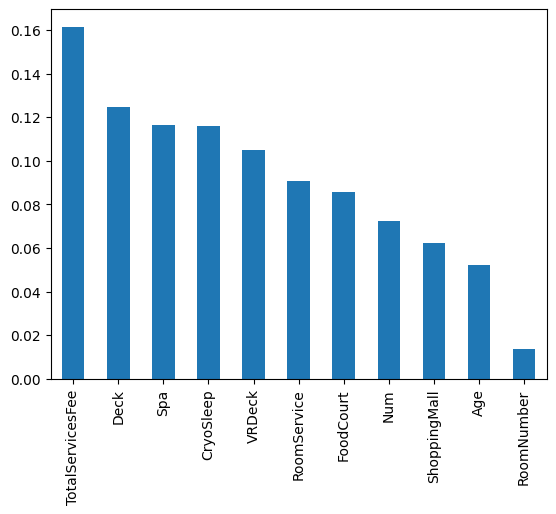

In [44]:
# Tune model
params = {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
model = RandomForestClassifier(**params)
model.fit(X_train, y_train)
important_features = pd.Series(data=model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(important_features)
important_features.plot(kind='bar')

In [45]:
train_prediction = model.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test,train_prediction)) # 0.799 % Accuracy
cv_scores = cross_val_score(model, X_train, y_train, cv=5) # Use cross-validation to estimate performance
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}") # Mean Cross-validation score 0.79 % Accuracy

Accuracy Score: 0.8039102932719954
Cross-validation scores: [0.78073329 0.79439252 0.79654925 0.7821711  0.8057554 ]
Mean cross-validation score: 0.7919203099059213


In [46]:
passenger_id = test['PassengerId']
transformed_test = feature_engineering(test)
intermediate_output = model.predict(X_train).reshape(-1, 1) # How much actually features we have ?

C:\Users\Tymur_Hilfatullin\AppData\Local\Temp\ipykernel_12084\1330618289.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['CryoSleep'] = df['CryoSleep'].fillna(False)


In [58]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.001,) # Early stopping to prevent overfitting

model2 = k_models.Sequential([ # Build the second DNN model
    Input(shape=(intermediate_output.shape[1],)),
    BatchNormalization(),
    Dense(16, activation='tanh'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='tanh'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Assuming 3 classes for classification
])

model2.compile(optimizer='adam', loss='mae', metrics=['accuracy']) # Compile the second model
history = model2.fit(intermediate_output, y_train, epochs=20, batch_size=64, validation_split=0.2, callbacks=[early_stopping], verbose=1) # Train the second model
intermediate_test_output = model.predict(X_test).reshape(-1, 1) # Evaluate the final model
loss, accuracy = model2.evaluate(intermediate_test_output, y_test, verbose=0)

print(f'Test Accuracy: {accuracy:.2f}')

Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8398 - loss: 0.1732 - val_accuracy: 0.8763 - val_loss: 0.2083
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8600 - loss: 0.1402 - val_accuracy: 0.8763 - val_loss: 0.1302
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8565 - loss: 0.1436 - val_accuracy: 0.8763 - val_loss: 0.1240
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8512 - loss: 0.1489 - val_accuracy: 0.8763 - val_loss: 0.1237
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8533 - loss: 0.1467 - val_accuracy: 0.8763 - val_loss: 0.1237
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8616 - loss: 0.1384 - val_accuracy: 0.8763 - val_loss: 0.1237
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8584 - loss: 0.1417 - val_accuracy: 0.8763 - val_loss: 0.1237
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8543 - loss: 0.1458 - val_accuracy: 0.8763 - val_loss:

In [48]:
intermediate_test_output2 = model.predict(transformed_test).reshape(-1, 1)
model_2_prediction = model2.predict(intermediate_test_output2)

134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step



Evaluation against Test Dataset :
------------------------------------

Model Accuracy :  0.8039103150367737

Model Loss :  0.19609245657920837
Best epoch :  11


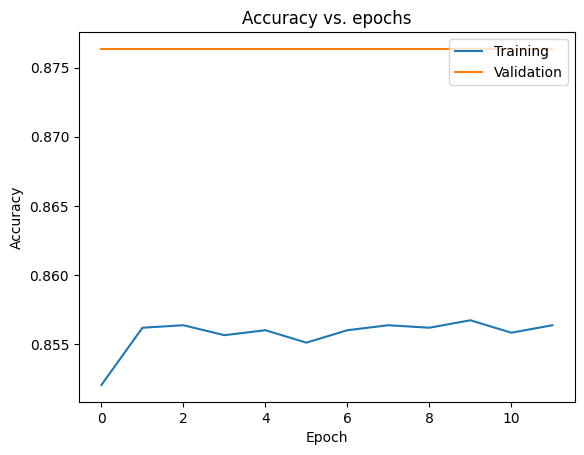

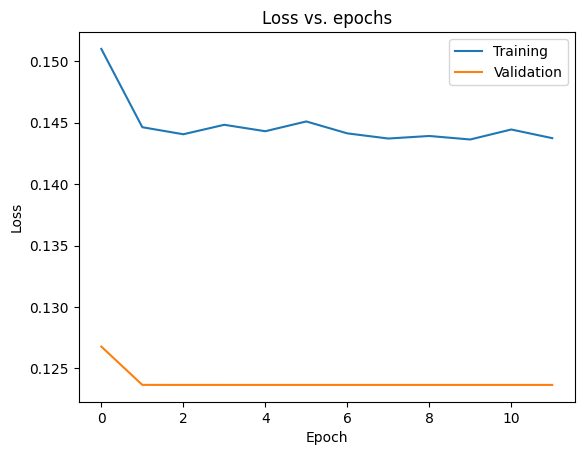

In [49]:
#Evaluate the model against the test dataset and print results
print("\nEvaluation against Test Dataset :\n------------------------------------")

# Show accuracy of the model
print("\nModel Accuracy : ", accuracy) # 0.87% accuracy
print("\nModel Loss : ", loss) # 0.87% accuracy

# best params
print("Best epoch : ", early_stopping.stopped_epoch)

# plot accuracy by epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Let's plot the loss over time.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [50]:
# Save results
output = pd.DataFrame({'PassengerId': passenger_id, 'Transported': model_2_prediction.argmax(axis=1)})
output['Transported'] = output['Transported'].astype(bool)
output.to_csv('data/space_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
